In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [13]:
df = pd.read_csv('../Get_Data_BTC/BTC_Daily_ohlc.csv')
start_date = "2022-12-26"
mask = (df["date"] > start_date) 
df = df.loc[mask]
df['SMA_5_days'] = df['close'].rolling(window=5).mean()
df['SMA_3_days'] = df['close'].rolling(window=3).mean()

start_date = "2023-01-01"
mask = (df["date"] > start_date) 
df = df.loc[mask]
print(df.head())



                     date          open          high           low  \
1962  2023-01-01 09:00:00  16541.712741  16627.970811  16498.995357   
1963  2023-01-02 09:00:00  16617.151524  16799.083296  16548.728098   
1964  2023-01-03 09:00:00  16672.738771  16778.293046  16605.277585   
1965  2023-01-04 09:00:00  16675.625716  16991.797881  16652.653952   
1966  2023-01-05 09:00:00  16850.336901  16879.759365  16753.013749   

             close    SMA_5_days    SMA_3_days  
1962  16616.741487  16589.426172  16588.828837  
1963  16672.871107  16614.555022  16610.645740  
1964  16675.135321  16622.898587  16654.915971  
1965  16850.347537  16671.484015  16732.784655  
1966  16831.809783  16729.381047  16785.764214  


In [14]:
def candleplot(df,  x_min = 0, x_max = len(df) , filename = "plot_BTC"):
    ## Figure params
    plt.figure(dpi = 200)
    plt.ylabel('price (dollars)')
    plt.title('Bitcoin')
    plt.xlabel('days')
    plt.grid(True)

    ## Import ohlc 
    opens = df['open'].values[x_min:x_max]
    truth = df['close'].values[x_min:x_max]
    highs = df['high'].values[x_min:x_max]
    lows = df['low'].values[x_min:x_max]
    sma = df['SMA_3_days'].values[x_min:x_max]

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')
    plt.bar(range(x_min,len(truth) + x_min), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(x_min, x_min + len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)
    plt.plot(range(x_min,len(truth) + x_min), sma, color = "purple")

    plt.savefig(f'./plot/{filename}')


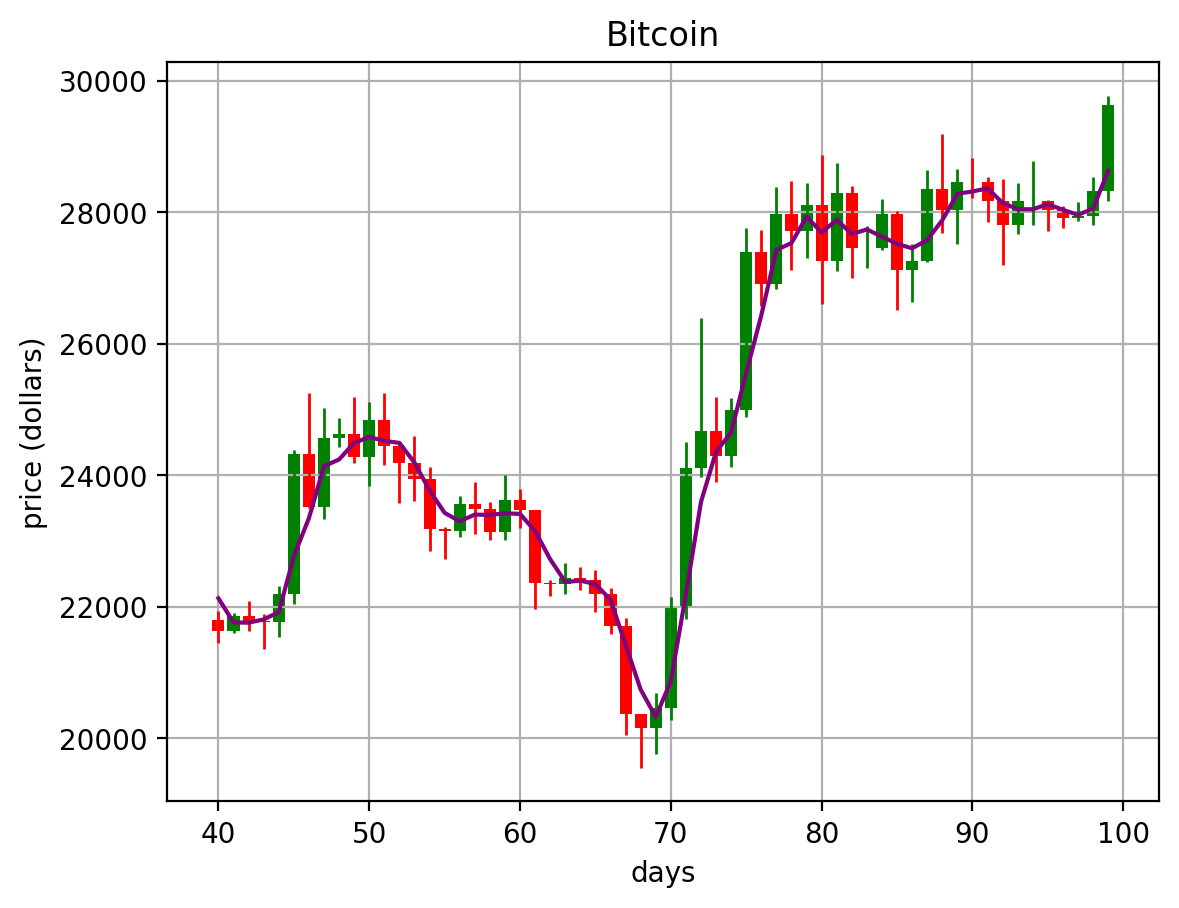

In [15]:
candleplot(df,  x_min = 40, x_max = 100 , filename = "test")